# Trees

Table of contents

✔ Chapter 1.  Decision trees

Chapter 2. Tree ensembles

To install further python libraries, type

`!pip install --target=$my_path [LIBRARY_NAME]`

# Chapter 1-1. Implement from scratch



Define the class "Node"

In [58]:
class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, *, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label
    
    def is_leaf(self):
        return self.label is not None

Then, define the class "DecisionTree"

Before that, let's look at each function to be included in the DecisionTree class

To traverse the tree, define the traverse function.

First, we need the test to determine the each node of the tree

To measure the quality of the test using each feature to determine the node, let's use the entropy

In [2]:
import numpy as np
def _entropy(self, y):
    # np.bincount: Count number of occurrences of each value in array
    weights = np.bincount(y) / len(y)
    entropy = -np.sum([w * np.log2(w) for w in weights if w > 0])
    return entropy

Second, more generally people use the information gain when expanding the tree.

The information gain can be computed by getting the difference between parent entropy and children_entropy

In [ ]:
# information_gain = parent_entropy - children_entropy
def _information_gain(self, X, y, value):
    parent_entropy = self._entropy(y)

    # expand the tree with X 
    left_idx, right_idx = self._expand_tree(X, value)

    n, n_left, n_right = len(y), len(left_idx), len(right_idx)

    if n_left == 0 or n_right == 0: 
        return 0
    
    # each node has two children (right child and left child)
    children_entropy = (n_left / n) * self._entropy(y[left_idx]) + (n_right / n) * self._entropy(y[right_idx])
    return parent_entropy - children_entropy

Third, split X based on values

In [ ]:
def _expand_tree(self, X, value):

    # np.argwhere: return indices of X which are less than and equal to value
    # np.flatten: turn multi-dimensional data into vectors
    left_idx = np.argwhere(X <= value).flatten()

    # return indices of X which are greater than 
    right_idx = np.argwhere(X > value).flatten()
    return left_idx, right_idx

OK, so now need the function to pick the best feature for each node among available features

In [ ]:
def _best_split(self, X, y, features):
    # create split dict in which we record score, feature, and value to keep the split yielding the maximum score 
    split = {'score':- 1, 'feat': None, 'value': None}

    # for each column in 30 columns
    for feat in features:
        # select one feature column
        # example: values in outlook column
        X_feat = X[:, feat] 

        # np.unique: remove duplicates
        # create values 
        values = np.unique(X_feat)

        # for each value in the column
        for value in values:
            
            # compute the information gain 
            score = self._information_gain(X_feat, y, value)

            # Update the split with the maximum score
            if score > split['score']:
                split['score'] = score
                split['feat'] = feat
                split['value'] = value
            
    # return the best split with the maximum score (i.e., information gain)
    return split['feat'], split['value']

Next, define the function to build the tree using the best feature picked before

In [ ]:
def _build_tree(self, X, y, depth=0):
    self.n_samples, self.n_features = X.shape
    self.n_class_labels = len(np.unique(y))

    # 1. Check whether go or stop: use stopping criteria using _stop function
    if self._stop(depth):
        most_common_Label = np.argmax(np.bincount(y))
        return Node(label=most_common_Label)
    
    # 2. find the best split: get the best feature for the current node among 30 features
    # random_f carries shuffled feature indices
    random_f = np.random.choice(self.n_features, self.n_features, replace=False)
    best_feat, best_value = self._best_split(X, y, random_f)

    # 3. expand the tree: create the subtrees using the best split
    left_idx, right_idx = self._expand_tree(X[:, best_feat], best_value)

    # 4. grow the left subtree and right subtree recursively
    left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
    right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
    return Node(best_feat, best_value, left_child, right_child)

Then, define the stopping criteria

In [ ]:
def _stop(self, depth):
    # use the restriction when creating the tree
    # first, tree depth (i.e., max_depth)
    # second, the number of remaining data point to be used in the split (i.e., min_samples_split)
    if (depth >= self.max_depth
        or self.n_class_labels == 1
        or self.n_samples < self.min_samples_split):
        return True
    return False

Wait, we need to traverse the tree so define it

In [ ]:
# For the evaluation using the testing set, we need a traverse function
def _traverse_tree(self, x, node):
    if node.is_leaf():
        return node.label
    
    # recursively traverse the tree (left subtree)
    # node.feature = feature index, so compare X to current node's value
    if x[node.feature] <= node.value:
        return self._traverse_tree(x, node.left)
    
    # recursively traverse the tree (right subtree)
    return self._traverse_tree(x, node.right)

Finally, define the fit and predict functions

In [ ]:
def fit(self, X, y):
    self.root = self._build_tree(X, y)

In [ ]:
# Given X, 
def predict(self, X):
    predictions = [self._traverse_tree(x, self.root) for x in X]
    return np.array(predictions)

Now, we go over all functions needed to define the class "DecisionTree"

In [59]:
class DecisionTree:

    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def _stop(self, depth):
        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False
    
    def _entropy(self, y):
        # np.bincount: Count number of occurrences of each value in array
        weights = np.bincount(y) / len(y)
        entropy = -np.sum([w * np.log2(w) for w in weights if w > 0])
        return entropy
    
    def _expand_tree(self, X, value):

        # np.argwhere: return indices of X which are less than and equal to value
        # np.flatten: turn multi-dimensional data into vectors
        left_idx = np.argwhere(X <= value).flatten()

        # return indices of X which are greater than 
        right_idx = np.argwhere(X > value).flatten()
        return left_idx, right_idx

    # information_gain = parent_entropy - children_entropy
    def _information_gain(self, X, y, value):
        parent_entropy = self._entropy(y)

        # expand the tree with X 
        left_idx, right_idx = self._expand_tree(X, value)

        n, n_left, n_right = len(y), len(left_idx), len(right_idx)

        if n_left == 0 or n_right == 0: 
            return 0
        
        # each node has two children (right child and left child)
        children_entropy = (n_left / n) * self._entropy(y[left_idx]) + (n_right / n) * self._entropy(y[right_idx])
        return parent_entropy - children_entropy
    
    def _best_split(self, X, y, features):
        # create split dict in which we record score, feature, and value to keep the split yielding the maximum score 
        split = {'score':- 1, 'feat': None, 'value': None}

        # for each column in 30 columns
        for feat in features:
            # select one feature column
            # example: values in outlook column
            X_feat = X[:, feat] 

            # np.unique: remove duplicates
            # create values 
            values = np.unique(X_feat)

            # for each value in the column
            for value in values:
                
                # compute the information gain 
                score = self._information_gain(X_feat, y, value)

                # Update the split with the maximum score
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['value'] = value
                
        # return the best split with the maximum score (i.e., information gain)
        return split['feat'], split['value']
    
    def _build_tree(self, X, y, depth=0):
        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # 1. Check whether go or stop: use stopping criteria using _stop function
        if self._stop(depth):
            most_common_Label = np.argmax(np.bincount(y))
            return Node(label=most_common_Label)
        
        # 2. find the best split: get the best feature for the current node among 30 features
        # random_f carries shuffled feature indices
        random_f = np.random.choice(self.n_features, self.n_features, replace=False)
        best_feat, best_value = self._best_split(X, y, random_f)

        # 3. expand the tree: create the subtrees using the best split
        left_idx, right_idx = self._expand_tree(X[:, best_feat], best_value)

        # 4. grow the left subtree and right subtree recursively
        left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_feat, best_value, left_child, right_child)
        
    def fit(self, X, y):
        self.root = self._build_tree(X, y)
    '''
    class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, *, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label
    
    def is_leaf(self):
        return self.label is not None
    '''
    
    # For the evaluation using the testing set, we need a traverse function
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.label
        
        # recursively traverse the tree (left subtree)
        # node.feature = feature index, so compare X to current node's value
        if x[node.feature] <= node.value:
            return self._traverse_tree(x, node.left)
        
        # recursively traverse the tree (right subtree)
        return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

Let's test our model using the dataset


*   dataset source: sklearn datasets 



In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

load breast cancer dataset

*   Consist of the following 30 features (and compute mean, stadard error (std / sqrt(N)), and the worst case)

  a) radius (mean of distances from center to points on the perimeter)

  b) texture (standard deviation of gray-scale values)

  c) perimeter

  d) area

  e) smoothness (local variation in radius lengths)

  f) compactness (perimeter^2 / area - 1.0)

  g) concavity (severity of concave portions of the contour)

  h) concave points (number of concave portions of the contour)

  i) symmetry

  j) fractal dimension ("coastline approximation" - 1)

In [3]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

Overview the dataset

In [35]:
import pandas as pd

df = pd.DataFrame(X_train)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,20.66,117.80,991.7,0.10360,0.13040,0.120100,0.088240,0.1992,0.06069,...,21.080,25.41,138.10,1349.0,0.14820,0.37350,0.33010,0.19740,0.3060,0.08503
1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.40000,0.16250,0.2364,0.07678
2,9.00,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833,...,9.699,20.07,60.90,285.5,0.09861,0.05232,0.01472,0.01389,0.2991,0.07804
3,12.21,14.09,78.78,462.0,0.08108,0.07823,0.068390,0.025340,0.1646,0.06154,...,13.130,19.29,87.65,529.9,0.10260,0.24310,0.30760,0.09140,0.2677,0.08824
4,12.34,14.95,78.29,469.1,0.08682,0.04571,0.021090,0.020540,0.1571,0.05708,...,13.180,16.85,84.11,533.1,0.10480,0.06744,0.04921,0.04793,0.2298,0.05974


In [38]:
X.shape

(569, 30)

Train DecisionTree model

In [60]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

Define the accuracy metric

In [44]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

Evaluate the trained DecisionTree model using testing set

In [61]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.956140350877193


# Chapter 1-2. Use scikit-learn library


In [1]:
from sklearn import tree

Define the tree model and train using training set

In [4]:
Dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=2, random_state=0)
Dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

Evaluate the trained tree using testing set

In [47]:
y_pred2 = Dtree.predict(X_test)
print('Accuracy: %.2f' % accuracy(y_test, y_pred2))

Accuracy: 0.95


Visualize the tree

In [9]:
from sklearn.tree import export_graphviz
import pydot
import graphviz

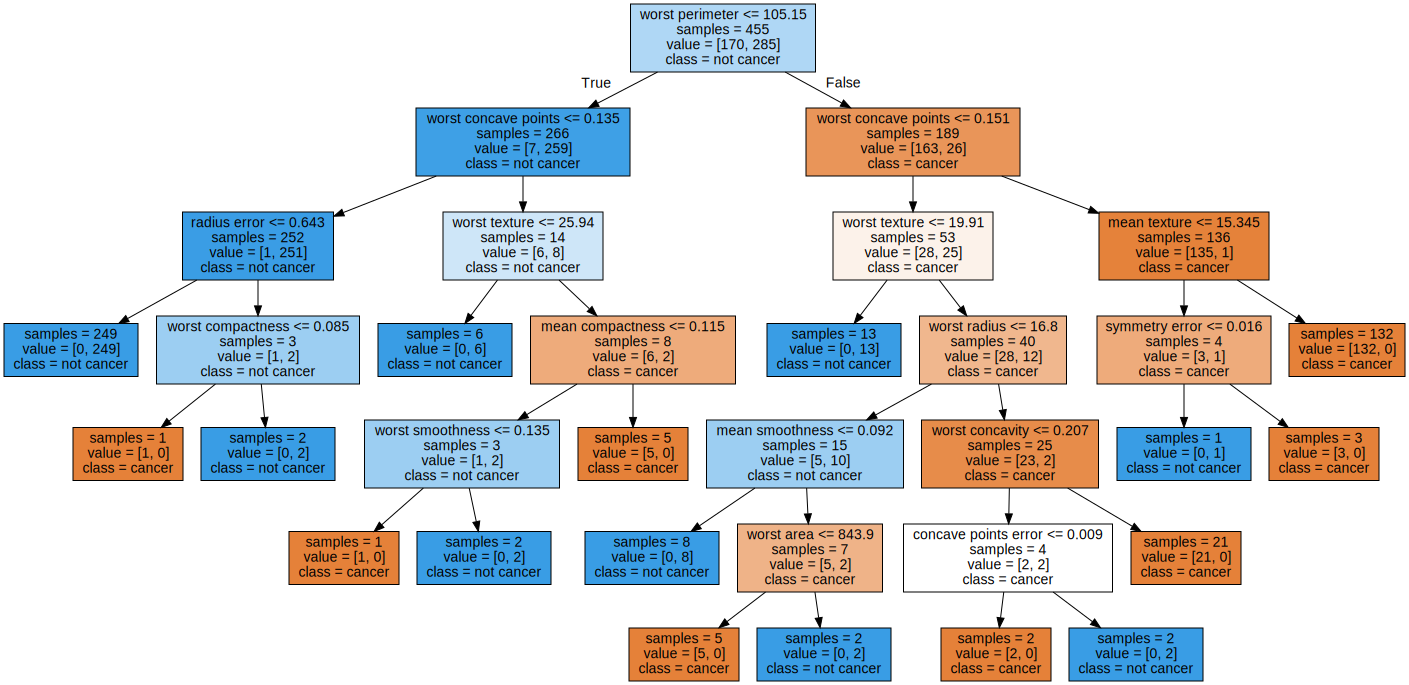

In [11]:
# Export the image to a dot file
export_graphviz(Dtree, out_file="tree.dot",feature_names=data.feature_names, class_names=["cancer","not cancer"], filled=True, impurity=False)
with open("tree.dot") as f :
    dot_graph = f.read()
display(graphviz.Source(dot_graph))